<a href="https://colab.research.google.com/github/luanakwon/GreatBarrierReef/blob/main/GBR_YOLOBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle api
kaggle  
https://www.kaggle.com/c/tensorflow-great-barrier-reef/data  

kaggle API usage  
https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

In [1]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=de8aa35afab8e9d021da502f955a4a717c43ad42873a074acd30fd12952d0c49
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
!kaggle competitions download -c tensorflow-great-barrier-reef

100% 14.2G/14.2G [02:39<00:00, 135MB/s]
100% 14.2G/14.2G [02:39<00:00, 95.3MB/s]


In [4]:
!unzip -q /content/tensorflow-great-barrier-reef.zip 

# Session 1
---
Useful links  
- [YOLOv5 - Train Custom Data github](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)  


In [5]:
# create hierarchy
import os

for f1 in 'train', 'val', 'test':
  for f2 in 'images', 'labels':
    os.makedirs(f'/content/Datasets/{f1}/{f2}')

In [6]:
# get train.csv
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


In [7]:
def annotation2YoloFormat(_annotation, width=1280, height=720):
  out= ''
  bboxes = eval(_annotation)
  for x in bboxes:
    x = list(x.values())
    out += '0 %.6f %.6f %.6f %.6f\n'%(
      max(0,min(1,(x[0]+x[2]/2)/width)),
      max(0,min(1,(x[1]+x[3]/2)/height)),
      max(0,min(1,x[2]/width)),
      max(0,min(1,x[3]/height))
    )
  return out.lstrip()

In [8]:
import cv2
import numpy as np

kernelx = cv2.getGaussianKernel(181,30)
kernely = cv2.getGaussianKernel(91,30)

def balance_ambient(src):
  ambient = cv2.sepFilter2D(src,-1,kernelx,kernely)
  balanced = (src.astype(np.float32)-(ambient*0.5))
  balanced = balanced*(balanced > 0)*(255/np.max(balanced))
  return balanced.astype(np.uint8)

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

TRAIN_DIRECTORY = "/content/Datasets/train"
VAL_DIRECTORY = "/content/Datasets/val"
BALANCE_AMBIENT = True

train, val = train_test_split(df_train, test_size=0.2,random_state=314)
train = train[train.annotations != '[]']
train.reset_index(inplace=True)
val.reset_index(inplace=True)

print("Starting sort/labeling...")
print(f'\tTrain dataset:     {len(train)} images, all with bbox')
print(f"\tValidation dataset {len(val)} images,",end=' ')
print(f"{len(val[val.annotations != '[]'])} with bbox",end='\n\n')

for idx, row in train.iterrows():
  path_from = f'/content/train_images/video_{row.video_id}/{row.video_frame}.jpg'
  path_to = os.path.join(TRAIN_DIRECTORY,f'images/{row.image_id}.jpg')
  lb_path_to = os.path.join(TRAIN_DIRECTORY,f'labels/{row.image_id}.txt')
  print(f'\r[{idx}/{len(train)}] FROM {path_from}...',end='\t\t')

  if BALANCE_AMBIENT:
    frame = cv2.imread(path_from)
    bal = balance_ambient(frame)
    cv2.imwrite(path_to,bal)
  else:
    shutil.move(path_from, path_to)

  with open(lb_path_to, 'w') as f:
    f.write(annotation2YoloFormat(row.annotations))

print()

for idx, row in val.iterrows():
  path_from = f'/content/train_images/video_{row.video_id}/{row.video_frame}.jpg'
  path_to = os.path.join(VAL_DIRECTORY,f'images/{row.image_id}.jpg')
  lb_path_to = os.path.join(VAL_DIRECTORY,f'labels/{row.image_id}.txt')
  print(f'\r[{idx}/{len(val)}] FROM {path_from}...',end='\t\t')

  if BALANCE_AMBIENT:
    frame = cv2.imread(path_from)
    bal = balance_ambient(frame)
    cv2.imwrite(path_to,bal)
  else:
    shutil.move(path_from, path_to)
  
  if row.annotations != '[]':
    with open(lb_path_to, 'w') as f:
      f.write(annotation2YoloFormat(row.annotations))


Starting sort/labeling...
	Train dataset:     3929 images, all with bbox
	Validation dataset 4701 images, 990 with bbox

[3928/3929] FROM /content/train_images/video_1/6928.jpg...		
[4700/4701] FROM /content/train_images/video_2/4331.jpg...		

In [10]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-253-ga45e472 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 75.0/166.8 GB disk)


# Train under /content/yolov5

In [11]:
#### DID YOU CHANGE HYP.YAML ??? ####
# flipud: 0.5  # image flip up-down (probability)
# mosaic: 0.5  # image mosaic (probability)
# mixup: 0.5 # image mixup (probability)
input('DID YOU CHANGE HYP.YAML ???')

DID YOU CHANGE HYP.YAML ???y


'y'

In [12]:
# create yaml file and save to /data (your at /content/yolov5)
# https://drive.google.com/file/d/1BBrQ5_1urHvJdYOmYPR-HalMeF9dnK37/view?usp=sharing
!gdown --id 1BBrQ5_1urHvJdYOmYPR-HalMeF9dnK37 -O /content/yolov5/data/GBR.yaml

Downloading...
From: https://drive.google.com/uc?id=1BBrQ5_1urHvJdYOmYPR-HalMeF9dnK37
To: /content/yolov5/data/GBR.yaml
100% 428/428 [00:00<00:00, 736kB/s]


In [29]:
# Train YOLOv5m
# --img : image size (size,size)
# --batch : batch size
# --epochs : epochs
# --data : .yaml file name
# --weights : pretrained weights ('' --cfg yolov5s.yaml if from scratch)
%cd /content/yolov5

!python train.py \
--resume \
--hyp /content/yolov5/data/hyps/hyp.scratch.yaml \
--img 2048 \
--batch 6 \
--epochs 25 \
--data GBR.yaml \
--optimizer Adam \
--weights /content/yolov5/runs/train/exp3/weights/last.pt

/content/yolov5
train: weights=/content/yolov5/runs/train/exp3/weights/last.pt, cfg=, data=GBR.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch.yaml, epochs=25, batch_size=6, imgsz=2048, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/exp3/weights/last.pt
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.001, lrf=0.1, momentum=0.9, weight_decay=0.0005, warmup_epochs=2.0, warmup_mome

In [ ]:
# save exp as zip
%cd /content/yolov5/runs/train/exp8
!zip /content/exp8.zip -r *

# Visualization

In [ ]:
%cd /content/yolov5
!python detect.py --img 1280\
 --source ../Datasets/val/images\
 --weights ../best.pt\
 --data data/GBR.yaml\
 --nosave\
 --save-txt\
 --save-conf\
 --conf-thres 0.1\
 --iou-thres 0.3\
 --max-det 50

/content/yolov5
detect: weights=['../best.pt'], source=../Datasets/val/images, data=data/GBR.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.3, max_det=50, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-242-gf40854b torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
image 1/4696 /content/Datasets/val/images/0-0.jpg: 768x1280 1 reef, Done. (0.023s)
image 2/4696 /content/Datasets/val/images/0-1001.jpg: 768x1280 2 reefs, Done. (0.016s)
image 3/4696 /content/Datasets/val/images/0-1009.jpg: 768x1280 1 reef, Done. (0.015s)
image 4/4696 /content/Datasets/val/images/0-1014.jpg: 768x1280 1 reef, Done. (0.016s)
image 5/4696 /content/Dataset

In [ ]:
%cd /content/yolov5/runs/detect/exp2/labels
!zip /content/exp_pred_labels2.zip *.txt
%cd /content/Datasets/val/labels
!zip /content/exp_true_labels2.zip *.txt
%cd /content

/content/yolov5/runs/detect/exp2/labels
  adding: 0-0.txt (deflated 14%)
  adding: 0-1001.txt (deflated 34%)
  adding: 0-1009.txt (deflated 18%)
  adding: 0-1014.txt (deflated 13%)
  adding: 0-1020.txt (deflated 10%)
  adding: 0-1024.txt (deflated 9%)
  adding: 0-1026.txt (deflated 15%)
  adding: 0-1029.txt (deflated 35%)
  adding: 0-1030.txt (deflated 42%)
  adding: 0-1038.txt (deflated 34%)
  adding: 0-1117.txt (deflated 16%)
  adding: 0-1122.txt (deflated 19%)
  adding: 0-1132.txt (deflated 13%)
  adding: 0-1136.txt (deflated 14%)
  adding: 0-11426.txt (deflated 48%)
  adding: 0-11427.txt (deflated 56%)
  adding: 0-11429.txt (deflated 17%)
  adding: 0-11436.txt (deflated 48%)
  adding: 0-11440.txt (deflated 49%)
  adding: 0-11441.txt (deflated 14%)
  adding: 0-11451.txt (deflated 35%)
  adding: 0-11454.txt (deflated 34%)
  adding: 0-11460.txt (deflated 39%)
  adding: 0-11471.txt (deflated 33%)
  adding: 0-11486.txt (deflated 14%)
  adding: 0-11535.txt (deflated 9%)
  adding: 0-11586

In [ ]:
%cd /content/yolov5
# visualize
from utils.plots import plot_results 
plot_results('./runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'

/content/yolov5


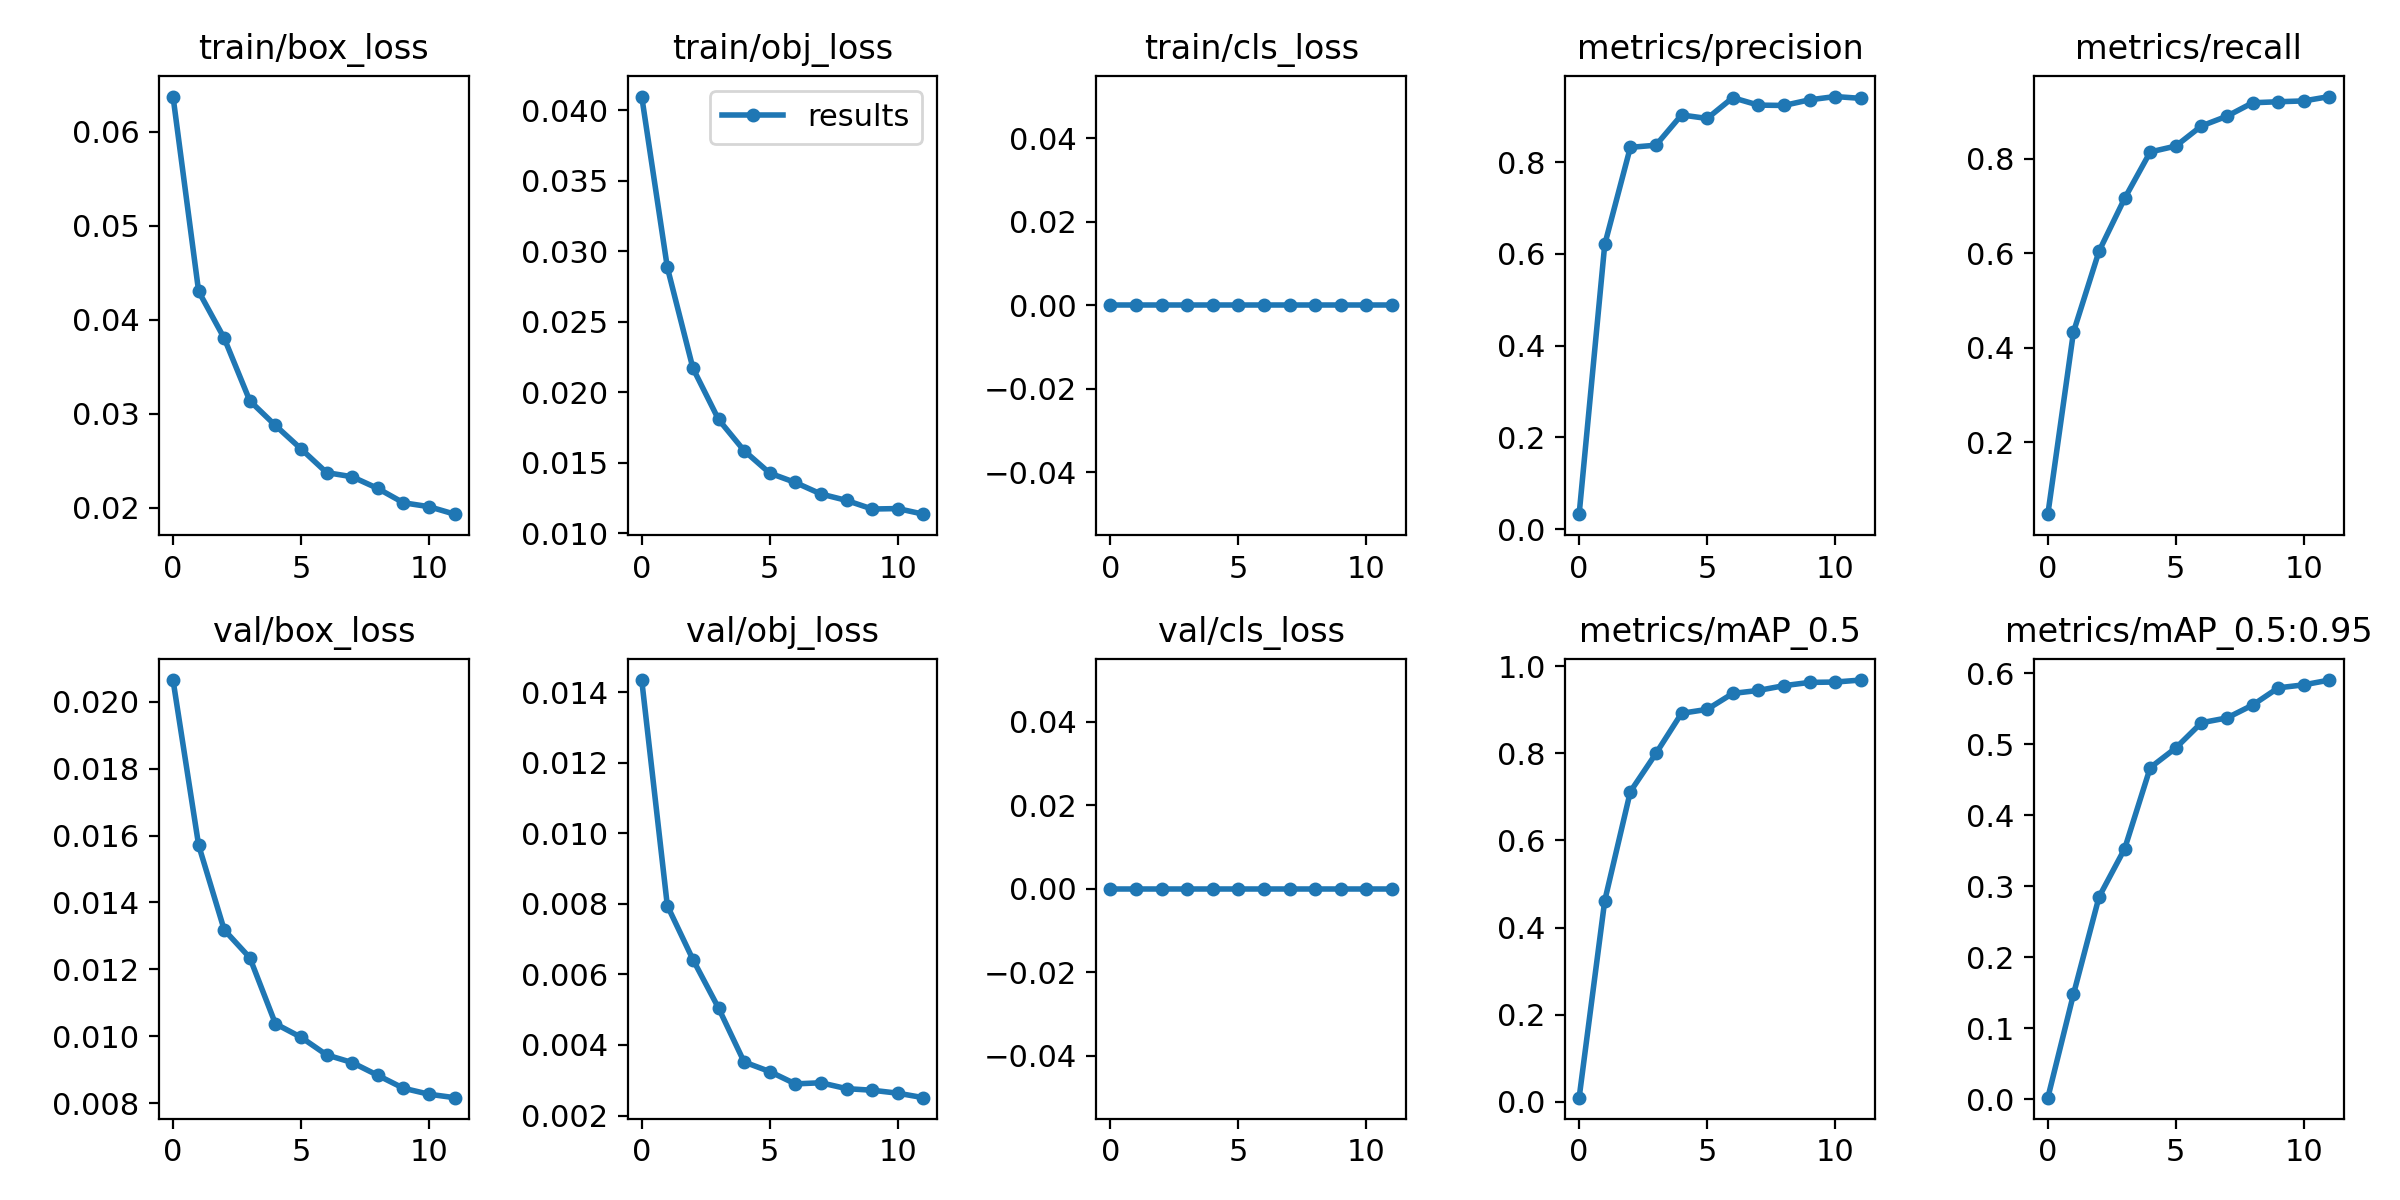

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread('/content/yolov5/runs/train/exp/results.png'))

# Inference on validation set

In [30]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
  model = torch.hub.load('/content/yolov5',
                          'custom',
                          path=ckpt_path,
                          source='local',
                          force_reload=True)  # local repo
  model.conf = conf  # NMS confidence threshold
  model.iou  = iou  # NMS IoU threshold
  model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
  model.multi_label = False  # NMS multiple labels per box
  model.max_det = 1000  # maximum number of detections per image
  return model

In [31]:
def predict(model, img, size=768, augment=False):
  height, width = img.shape[:2]
  results = model(img, size=size, augment=augment)  # custom inference size
  preds   = results.pandas().xyxy[0]
  bboxes  = preds[['xmin','ymin','xmax','ymax']].values
  if len(bboxes):
    bboxes[:,2:] -= bboxes[:,:2]
    bboxes  = bboxes.astype(int)
    confs   = preds.confidence.values
    return bboxes, confs
  else:
    return [],[]

def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

In [32]:
import cv2
import numpy as np

# calculate IoU
# pred = (x, y, width, height)
# label = (x, y, width, height)
def getIoU(pred, label):

  area_label = label[2] * label[3]
  area_predict = pred[2] * pred[3]
  area_of_overlap = max(0,min(label[0]+label[2]*0.5, pred[0]+pred[2]*0.5)\
                  - max(label[0]-label[2]*0.5, pred[0]-pred[2]*0.5))\
                  * \
                  max(0,min(label[1]+label[3]*0.5, pred[1]+pred[3]*0.5) \
                  - max(label[1]-label[3]*0.5, pred[1]-pred[3]*0.5))
  area_of_union = area_label + area_predict - area_of_overlap
  return area_of_overlap / area_of_union

def getConfusion(bboxes, confis, labels, iou_thres,
                 conf_min=0, conf_max=1, conf_step=0.1):
  # list of [x,y,w,h,conf]
  b4c1 = [[*b,c] for b, c in zip(bboxes,confis)]
  b4c1.sort(key=lambda x : x[4]) # sort in ascending order
  # confusion matrix [conf_thres,tp,fp,fn]
  cm = np.zeros((int((conf_max-conf_min)/conf_step)+1,4))
  for i, c in enumerate(cm):
    c[0] = conf_min+i*conf_step
  # make confusion matrix for all conf thres
  for conf_idx in range(cm.shape[0]):
    lbs = labels.copy()
    bc = b4c1.copy()
    for i, x in enumerate(bc):
      if x[4] > cm[conf_idx,0]:
        bc = bc[i:]
        break
    
    trues = len(lbs)
    # find pred-label match
    for sub_box in reversed(bc):
      for l in lbs:
        if getIoU(sub_box[:-1],l) > iou_thres:
          cm[conf_idx,1] += 1
          bc.remove(sub_box)
          lbs.remove(l)
          break
    # remains are False Positive and False Negative each
    cm[conf_idx,2] = len(bc)
    cm[conf_idx,3] = len(lbs)
  
    
  return cm[:,1:]

In [33]:
%cd /content

/content


In [35]:
IMG_SIZE = 2048
CONF_MIN = 0.3
CONF_MAX = 0.4
CONF_STEP = 0.01
VAL_DIRECTORY = '/content/Datasets/val'
LEN_VAL_DIR = len(os.listdir(f'{VAL_DIRECTORY}/images'))
conf_steps = int((CONF_MAX-CONF_MIN)/CONF_STEP)+1

my_model = load_model('/content/yolov5/runs/train/exp3/weights/best.pt', conf=CONF_MIN, iou=0.3)
m_confusions = np.zeros((11,conf_steps,3)) 

for idx,img_f in enumerate(os.listdir(f'{VAL_DIRECTORY}/images')):
  if idx > 4701:
    break
  
  path = f'{VAL_DIRECTORY}/images/{img_f}'
  print(f'\r[{idx}/{LEN_VAL_DIR}]{path}',end='\t\t')
  img = cv2.imread(path)[...,::-1]
  annot = eval(df_train[df_train.image_id == img_f[:-4]].annotations.item())
  # my model
  bboxes, confis = predict(my_model, img, size=IMG_SIZE, augment=True)

  for iou_idx in range(11): # iou thres from 0.3 to 0.8 step 0.05
    iou_thres = 0.05*iou_idx+0.3
    labels = [list(x.values()) for x in annot]
    m_confusions[iou_idx] += getConfusion(bboxes, confis, labels, iou_thres,
                                          CONF_MIN,CONF_MAX,CONF_STEP)

       

print()
# result - my model
confusions = m_confusions
# print(confusions)
# prevent zero division
no_tp = confusions[:,:,0] == 0
confusions[:,:,0] += no_tp

precisions = confusions[:,:,0]/(confusions[:,:,0]+confusions[:,:,1])
recalls = confusions[:,:,0]/(confusions[:,:,0]+confusions[:,:,2])
f2s = (5*precisions*recalls)/(4*precisions+recalls)

f2s *= np.logical_not(no_tp)
for i in range(conf_steps):
  print(CONF_MIN+CONF_STEP*i, end='  ')
print()
print(f2s)
print(np.mean(f2s,axis=(0)))

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.0-253-ga45e472 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


[4700/4701]/content/Datasets/val/images/1-909.jpg		
0.3  0.31  0.32  0.32999999999999996  0.33999999999999997  0.35  0.36  0.37  0.38  0.39  0.4  
[[    0.88163     0.88149     0.88158     0.88251     0.88244     0.88272     0.88254     0.88201     0.88265     0.88187     0.88146]
 [    0.88201     0.88188     0.88197      0.8829     0.88283     0.88311     0.88293      0.8824     0.88304     0.88226     0.88185]
 [    0.88124      0.8811     0.88119     0.88212     0.88206     0.88233     0.88215     0.88162     0.88226     0.88148     0.88106]
 [    0.87622     0.87607     0.87615     0.87708     0.87739     0.87766     0.87747     0.87694     0.87758     0.87679     0.87676]
 [    0.86308     0.86292     0.86298     0.86388     0.86417     0.86444     0.86423     0.86368      0.8643     0.86389     0.86385]
 [    0.84222     0.84204     0.84244      0.8433     0.84357     0.84383     0.84359     0.84302     0.84361     0.84317     0.84311]
 [    0.81093     0.81071     0.81105     0

# Submit

In [ ]:
# kaggle submission code

import greatbarrierreef

env = greatbarrierreef.make_env()
iter_test = env.iter_test()

for pixel_array, sample_pred_df in iter_test:
  bal_src = balance_ambient(pixel_array)
  bboxes, confs = predict(model,bal_src,size=1280,augment=True)
  annot = format_prediction(bboxes, confs)
  sample_pred_df['annotations'] = annot
  env.predict(sample_pred_df)